## Ludwig, 2020 Code to Calculate Xray Luminosity for Binary Stripped Star - Neutron Star Source.  
## Calculation by Ylva Gotberg and Katelyn Breivik 
  
### Dependencies :  
https://pypi.org/project/tabula-py/
and latex (for plots)

pip install tabula-py (not tabula!)


## Luminosity Calculation: 
### Assumptions: 
#### - $\beta = 1$
#### - $v_{\infty}$ from Gotberg 2018 table
#### - $\alpha = 1.5$

### Step 1: Calculate "a"
#### For Period, V_orbit, assume Kepler's laws : 
#### Note: For a tight orbit, assume circular geometry, a = r (distance between orbitting object and stripped star)   
#### $ P^2 = \frac{4\pi^2}{G}\frac{a^3}{(M_1 + M_2)} $  
#### $ a = \big(\frac{P^2 G (M_{stripped} + M_{companion})}{4 \pi^2}\big)^{1/3} $  

### Step 2: Calculate Roche Lobe Radius 
#### $ q = \frac{M_{stripped}}{M_{companion}} $
#### $ R_{Roche Lobe, Stripped} = a \; \frac{0.49 \; q^{2/3}}{0.6 \; q^{2/3} + \ln(1+q^{1/3})}$

### Step 3: Calculate Orbital Velocity
#### $ \omega = \frac{2\pi}{P} $
#### $ v_{orbit} = a \; \omega  $

### Step 4: Calculate Wind Velocity. 
#### $ v_{wind} = v_\infty (1 - \frac{R_{star}}{a})^\beta $

### Step 5: Calculate Relative Velocity. 
####  $ v_{relative} = \sqrt{v_{wind}^2 + v_{orbit}^2}$

### Step 6: Calculate Mass Accretion Rate
#### $ \dot{M}_{acc} =  \frac{\alpha \; G^2 \; M_{companion}^2 \dot{M}_{wind} }{ 2 \; v_{relative}^3 \; a^2 \; v_{wind} } $

### Step 7: Calculate Uncorrected Luminosity 
#### $ L_{uncorrected} =  \frac{G\; M_{companion}\;\dot{M}_{acc}}{R_{companion}} $

### Step 8: Calculate Opacity - Assume Kramer's Law, Electron Opacity is Dominant. 
#### $ \kappa = 0.02 (1 + X) $

### Step 9: Calculate Eddington Luminosity and Mass Loss Rate
#### $L_{Eddington} = \frac{4\pi c G M_{companion}}{\kappa}$
#### $\dot{M}_{Eddington} = \frac{L_{Eddington}}{c^2}$

### Step 10: Calculate Eta
#### if $L_{uncorrected} > 0.1 L_{Eddington}$ : $\epsilon = 1$
#### if $L_{uncorrected} < 0.1 L_{Eddington}$ : $\epsilon = $ADAF$(\dot{M}_{acc},\dot{M}_{Eddington})$
##### Note: ADAF is currently giving very small values and is uncertain in this case so after talking to Katie we set epsilon to 0.1 instead for now 

### Step 11: Calculate Epsilon 
#### if $L_{uncorrected} > 0.05 L_{Eddington}$ : $\eta_{BH} = 0.75$ and $\eta_{NS} = 0.61$
#### if $L_{uncorrected} < 0.05 L_{Eddington}$ : $\eta_{BH} = 0.36$ and $\eta_{NS} = 0.29$

### Step 12: Calculate Final Luminosity 
#### $ L = \eta \epsilon L_{uncorrected}$

### Step 13: Check that the radius of the stripped star does not exceed the roche lobe. Remove if it does. 


In [1]:
import tabula
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import colors
import astropy.constants as const
import astropy.units as u
from matplotlib import lines
from matplotlib import rc
from matplotlib import cm
import seaborn as sns; sns.set()


In [2]:
# From Ylva's 2018 paper 


file = "https://arxiv.org/pdf/1802.03018.pdf"
table = tabula.read_pdf(file, pages="22", multiple_tables=False, silent=True)

# Clean Up the Table, Store units in case I need it later.
df = table
units = df.iloc[0]
df = df.drop([0])
df = df.drop(["Group"], axis=1)
df["Minit"] = (
    np.array([re.findall("\d+\.\d+", str) for str in df["Minit"]])
    .flatten()
    .astype(float)
)
df

,Minit,Pinit,Mstrip,"MH,tot",log10 L,log10 LH,T?,Teff,log10 geff,Reff,"XH,s","XHe,s",log10 Ṁwind,Γe,v∞,log10 Q0,log10 Q1,log10 Q2
1,2.00,4.6,0.37,0.003,0.7,-0.9,21.7,21.6,5.55,0.17,1.00,0.00,-12.0,0.000,1370,41.2,37.4,30.8
2,2.21,4.9,0.42,0.004,1.1,-0.5,25.3,25.2,5.56,0.18,1.00,0.00,-12.0,0.001,1430,42.1,38.9,31.4
3,2.44,5.3,0.47,0.005,1.3,-0.3,27.8,27.7,5.54,0.19,1.00,0.00,-12.0,0.001,1450,42.7,40.4,35.6
4,2.70,5.6,0.54,0.006,1.5,-0.1,30.4,30.2,5.51,0.21,0.96,0.04,-12.0,0.002,1480,43.5,41.0,35.2
5,2.99,6.0,0.62,0.007,1.8,0.2,32.9,32.8,5.47,0.24,0.96,0.04,-12.0,0.003,1500,44.4,43.3,38.4
6,3.30,6.4,0.7,0.008,2.0,0.5,35.4,35.2,5.44,0.26,0.96,0.04,-12.0,0.004,1520,45.1,44.3,39.2
7,3.65,6.8,0.8,0.01,2.2,0.8,38.6,38.4,5.44,0.28,0.52,0.48,-12.0,0.005,1570,45.6,44.3,38.6
8,4.04,7.3,0.92,0.012,2.4,1.0,40.7,40.5,5.39,0.32,0.51,0.49,-11.2,0.006,1570,45.9,45.0,38.2
9,4.46,7.8,1.05,0.015,2.6,1.3,43.3,43.1,5.35,0.36,0.58,0.42,-10.5,0.009,1600,46.2,45.6,39.6
10,4.93,8.3,1.2,0.019,2.8,1.6,45.6,45.4,5.3,0.4,0.50,0.50,-10.0,0.012,1600,46.5,45.9,40.2


## $\eta$ : 

In [3]:
eta_table = tabula.read_pdf(
    "http://www.tassosfragos.com/wp-content/uploads/2014/09/apj_764_1_41.pdf",
    pages="6",
    multiple_tables=False,
    silent=True,
)
eta_table

,Unnamed: 0,Absorption Corrected,Absorption Uncorrected
0,NaN,High-Soft State Low-Hard State,High-Soft State Low-Hard State
1,Energy Band,NS BH NS BH,NS BH NS BH
2,0.3–2 keV,0.06 ± 0.09 0.28 ± 0.20 0.08 ± 0.06 0.13 ± 0.11,0.05 ± 0.08 0.09 ± 0.10 0.05 ± 0.03 0.08 ± 0.06
3,0.3–7 keV,0.61 ± 0.09 0.75 ± 0.18 0.29 ± 0.12 0.36 ± 0.13,0.57 ± 0.09 0.48 ± 0.14 0.25 ± 0.08 0.30 ± 0.08
4,0.3–8 keV,0.67 ± 0.09 0.78 ± 0.16 0.31 ± 0.12 0.39 ± 0.13,0.63 ± 0.09 0.51 ± 0.13 0.27 ± 0.09 0.33 ± 0.10
5,0.3–10 keV,0.77 ± 0.08 0.82 ± 0.13 0.36 ± 0.13 0.43 ± 0.13,0.73 ± 0.08 0.55 ± 0.12 0.32 ± 0.10 0.38 ± 0.10
6,0.5–2 keV,0.06 ± 0.09 0.26 ± 0.19 0.08 ± 0.06 0.12 ± 0.09,0.05 ± 0.08 0.09 ± 0.10 0.05 ± 0.03 0.07 ± 0.05
7,0.5–10 keV,0.77 ± 0.08 0.80 ± 0.11 0.36 ± 0.13 0.42 ± 0.13,0.73 ± 0.07 0.55 ± 0.12 0.32 ± 0.10 0.37 ± 0.10
8,2–10 keV,0.71 ± 0.08 0.54 ± 0.12 0.28 ± 0.09 0.30 ± 0.11,0.68 ± 0.07 0.46 ± 0.09 0.27 ± 0.08 0.30 ± 0.11


## $\epsilon$ : 

Per https://arxiv.org/pdf/1207.3113.pdf this varies between 0.01 and 0.1. Ish? Table 1 seems more complicated... I haven't carefully read this yet.

In [90]:
# Assuming band 0.3 - 7 KeV, absorption corrected

class xray:
    def __init__(
        self,
        table,
        period,
        M_NS=1.4 * const.M_sun,
        R_NS=10 * u.km,
        M_BH=5 * const.M_sun,
        M_WD=0.6 * const.M_sun,
        R_WD=0.005 * const.R_sun,
        beta=1,
        alpha=1.5,
        hydrogen_mass_fraction=0.02,
        dM_wind_coeff = 0.1,
        adaf_flag = False
    ):
        
        ###########
        # Set Up  #
        ###########
        
        # Power Law Exponent for v_wind added to class object   
        self.beta = beta
        self.alpha = alpha
        self.hydrogen_mass_fraction = hydrogen_mass_fraction
        
        # Add units to quantities
        self.period = period * u.day
        self.M_stripped = table["Mstrip"].to_numpy(dtype=float) * const.M_sun
        self.R_stripped = table["Reff"].to_numpy(dtype=float) *  const.R_sun
        self.v_inf = table["v∞"].to_numpy(dtype=float) * u.km / u.s
            
        # Get wind mass loss rates from Ylva's table. Add units. Multiply by a factor to adjust for new information. Default is by 0.1    
        self.dM_wind = dM_wind_coeff * (10 ** table["log10 Ṁwind"].to_numpy(dtype=float)) * const.M_sun / u.year
        
        ################################################################
        # Calculate the Accretion Xray Luminosity given a Neutron Star #
        ################################################################
        
        self.neutron_star_luminosity = self.calculate_luminosity(M_NS, R_NS,adaf_flag)
        
        ##############################################################
        # Calculate the Accretion Xray Luminosity given a Black Hole #
        ##############################################################
        
        # Schwarzschiled Radius 
        self.R_schwarzschild = 2 * const.G * M_BH / const.c ** 2
        
        # Assume the Radius of the Black Hole for accretion purposes is 3 times the Schwarzschild Radius 
        self.R_bh_accretion = 3 * self.R_schwarzschild

        # Calculate the Black Hole Luminosity 
        self.black_hole_luminosity = self.calculate_luminosity(M_BH, self.R_bh_accretion,adaf_flag) 
        
    #######################
    # Luminosity Function #
    #######################
    
    def calculate_luminosity(self, companion_mass, companion_radius,adaf_flag):

        # Step 1: Calculate "a" or distance between companion and stripped star
        self.distance = ((
            self.period ** 2 * const.G * (self.M_stripped + companion_mass) / (4 * np.pi ** 2)
        ) ** (1 / 3)).to(u.km)
        
        # Step 2: Calculate Roche Lobe 
        self.q = self.M_stripped / companion_mass
        self.roche_lobe = self.distance * (0.49 * self.q ** (2 / 3)) / (0.6 * self.q ** (2 / 3) + np.log(1 + self.q ** (1/3)))   

        # Step 3: Calculate Orbital Velocity
        self.omega_orbit = 2 * np.pi / self.period

        self.v_orbit = (self.omega_orbit * self.distance).to( u.km / u.s)
            
        # Step 4: Calculate Wind Velocity 
        self.v_wind = self.v_inf * (1 - self.R_stripped / self.distance) ** self.beta
        
        # Step 5: Calculate Relative Velocity
        self.v_relative = np.sqrt(self.v_wind ** 2 + self.v_orbit ** 2)
        
        # Step 6: Calculate Mass accretion rate
        self.dM_acc = (self.alpha * const.G ** 2 * companion_mass ** 2 * self.dM_wind).to(u.kg *u.km**6 / (u.s**4* u.yr)) / (
            2 * self.v_relative ** 3 * self.distance ** 2 * self.v_wind
        )
        
        self.dM_acc = self.dM_acc.to(u.M_sun / u.year)

        # Step 7: Calculate Uncorrected Luminosity
        self.L_uncorrected = (const.G * companion_mass * self.dM_acc / companion_radius).to(
            u.erg / u.s
        )

        # Step 8: Calculate Opacity - Assume Electron Scattering is Dominant. 
        self.kramers_opacity = 0.02 * (1 + self.hydrogen_mass_fraction) * u.cm ** 2 / u.g
        
        # Step 9: Calculate Eddington Luminosity and Mass 
        self.L_eddington = (
            4 * np.pi * const.c * const.G * companion_mass / self.kramers_opacity
        ).to(u.erg / u.s)

        self.dM_eddington = (self.L_eddington / (const.c ** 2)).to(u.M_sun/u.year)
        
        # Step 10 : Calculate Epsilon
        self.epsilons, self.etas = [],[]
        for luminosity, dM_accretion,counter in zip(self.L_uncorrected,self.dM_acc,np.arange(0,len(self.L_uncorrected))) : 
            # Calculate correction Factors eta and epsilon.

            if luminosity > 0.1 * self.L_eddington:

                epsilon = 1

            elif luminosity < 0.1 * self.L_eddington:

                if adaf_flag:
                    epsilon = self.calculate_ADAF_efficiency(
                        dM_accretion, self.dM_eddington
                    )
                    print("M_stripped",self.M_stripped[counter].to(u.M_sun))
                    print("M_companion",companion_mass.to(u.M_sun))
                    print("Epsilon:", epsilon)
                    print("Accretion Rate:", dM_accretion)
                    print("Eddington Mass Loss Rate:",self.dM_eddington)
                    print("Uncorrected Luminosity:", luminosity)
                    print("Eddington Luminosity:",self.L_eddington)
                    print(" ")
                    print(" ")
                else:
                
                    epsilon = 0.1
                    
        # Step 11 : Calculate Eta        
            if luminosity > 0.05 * self.L_eddington:
                # High Soft State

                # Black Hole 
                if companion_mass > 3 * const.M_sun:

                    eta = 0.75

                # Neutron Star
                else:

                    eta = 0.61


            # Assuming band 0.3 - 8 KeV
            elif luminosity < 0.05 * self.L_eddington:
                # Low Hard State

                # Black Hole 
                if companion_mass > 3 * const.M_sun:

                    eta = 0.36

                # Neutron Star
                else:

                    eta = 0.29
            
            self.epsilons.append(epsilon)
            self.etas.append(eta)
         
        # Step 12: Remove if the radius of the stripped star is the same or greater than the roche lobe radius.
        
        truth = []
        
        for R, RL in zip (self.R_stripped, self.roche_lobe):
            
            if R >= RL : 
                            
                truth.append(np.nan)
            
            else:
                
                truth.append(1.)
            
        
        
        # Calculate Final Luminosity
        self.L = self.L_uncorrected * np.array(self.epsilons) * np.array(self.etas) * truth
        

        
            
        return self.L

        # This is epsilon

    def calculate_ADAF_efficiency(self, Mdot, Mdot_edd, delta=0.01):
        """
        Written by Ylva/Katie. 
        Calculate the mass-luminosity efficiency based on the ADAF
        model of Xie & Yuan (2012), using the piecewise fitting function
        using values provided their Table 1 for their Equation 11.

        Args:
            Mdot : mass transfer rate onto a BH [msun/year]
            Mdot_edd : Eddington mass transfer rate (same units as Mdot)
            delta : (optional) fraction of ionization energy acting on electrons

        Returns:
            epsilon : mass-light conversion efficiency
        """

        M_ratio = Mdot / Mdot_edd
        
        print("ADAF M_ratio", M_ratio)

        if not delta in [0.5, 0.1, 0.01, 0.001]:
            print("You must provide an acceptable value for delta.")
            sys.exit(-1)

        if delta == 0.5:
            conds = [
                M_ratio < 2.9e-5,
                (M_ratio >= 2.9e-5) & (M_ratio < 3.3e-3),
                (M_ratio >= 3.3e-3) & (M_ratio < 5.3e-3),
                M_ratio >= 5.3e-3,
            ]
            func_epsilon = [
                lambda M_ratio: 1.58 * (100 * M_ratio) ** 0.65,
                lambda M_ratio: 0.055 * (100 * M_ratio) ** 0.076,
                lambda M_ratio: 0.17 * (100 * M_ratio) ** 1.12,
                lambda M_ratio: 0.1,
            ]

        if delta == 0.1:
            conds = [
                M_ratio < 9.4e-5,
                (M_ratio >= 9.4e-5) & (M_ratio < 5.0e-3),
                (M_ratio >= 5.0e-3) & (M_ratio < 6.6e-3),
                M_ratio >= 6.6e-3,
            ]
            func_epsilon = [
                lambda M_ratio: 0.12 * (100 * M_ratio) ** 0.59,
                lambda M_ratio: 0.026 * (100 * M_ratio) ** 0.27,
                lambda M_ratio: 0.50 * (100 * M_ratio) ** 4.53,
                lambda M_ratio: 0.1,
            ]

        if delta == 1.0e-2:
            conds = [
                M_ratio < 1.6e-5,
                (M_ratio >= 1.6e-5) & (M_ratio < 5.3e-3),
                (M_ratio >= 5.3e-3) & (M_ratio < 7.1e-3),
                M_ratio >= 7.1e-3,
            ]
            func_epsilon = [
                lambda M_ratio: 0.069 * (100 * M_ratio) ** 0.69,
                lambda M_ratio: 0.027 * (100 * M_ratio) ** 0.54,
                lambda M_ratio: 0.42 * (100 * M_ratio) ** 4.85,
                lambda M_ratio: 0.1,
            ]

        if delta == 1.0e-3:
            conds = [
                M_ratio < 7.6e-5,
                (M_ratio >= 7.6e-5) & (M_ratio < 4.5e-3),
                (M_ratio >= 4.5e-3) & (M_ratio < 7.1e-3),
                M_ratio >= 7.1e-3,
            ]
            func_epsilon = [
                lambda M_ratio: 0.065 * (100 * M_ratio) ** 0.71,
                lambda M_ratio: 0.020 * (100 * M_ratio) ** 0.47,
                lambda M_ratio: 0.26 * (100 * M_ratio) ** 3.67,
                lambda M_ratio: 0.1,
            ]
        return np.piecewise(M_ratio, conds, func_epsilon)

In [91]:
## Debug Cell, Why is Adaf giving so low values? 

Xray = xray(df,1,adaf_flag=True)


ADAF M_ratio 1.0478822935160612e-09
M_stripped 0.37 solMass
M_companion 1.3999999999999997 solMass
Epsilon: 1.054058505608743e-06
Accretion Rate: 6.349056941521729e-17 solMass / yr
Eddington Mass Loss Rate: 6.05894095244049e-08 solMass / yr
Uncorrected Luminosity: 7.43277241064481e+29 erg / s
Eddington Luminosity: 3.4311528808856354e+39 erg / s
 
 
ADAF M_ratio 8.753850172449301e-10
M_stripped 0.42 solMass
M_companion 1.3999999999999997 solMass
Epsilon: 9.310360043586854e-07
Accretion Rate: 5.303906130138131e-17 solMass / yr
Eddington Mass Loss Rate: 6.05894095244049e-08 solMass / yr
Uncorrected Luminosity: 6.209225640255767e+29 erg / s
Eddington Luminosity: 3.4311528808856354e+39 erg / s
 
 
ADAF M_ratio 8.189805138625522e-10
M_stripped 0.47 solMass
M_companion 1.3999999999999997 solMass
Epsilon: 8.892171969239712e-07
Accretion Rate: 4.962154574692574e-17 solMass / yr
Eddington Mass Loss Rate: 6.05894095244049e-08 solMass / yr
Uncorrected Luminosity: 5.809140784188644e+29 erg / s
Eddi

In [30]:
labelsize = 26
ticksize = 20
textsize = 20
legendsize = 18
ypad = 15
titlesize = 40
progenitor_sep = -0.25
progenitorsize = 15
fsize = 30



targetcolor = "#7575cf"
sky2 = np.array([84, 107, 171]) / 255.0  # color of stripped stars
blue2 = np.array([9, 7, 52]) / 255.0  # Color of other stars
blue1 = np.array([13, 193, 231]) / 255.0  # Background for UV excess (apply alpha=0.03)
violet2 = np.array([161, 25, 107]) / 255.0  # models
royalblue = "#0000ff"
# xcand "#0099b5"
purple1 = np.array([54, 27, 77]) / 255
purple2 = np.array([164,162,197])/255

lightblue = np.array([88, 149, 169]) / 255
darkblue = np.array([51, 73, 110]) / 255
mediumblue = np.array([164, 162, 197]) / 255  # np.array([51,73,110])*2/255

targetcolor = "#7575cf"

def rgba(r,g,b,a):
    return(r/255,g/255,b/255,a)

orig = rgba(178,178,255,1)

colors = ['r','b','g','purple','navy']
colors=[sky2,blue2,blue1,violet2,royalblue,purple1,purple2,mediumblue]
colors = ["#222c37","#00cccc","#fff600","#ff0066","#19e3b1","#ff7f33","#b83c82"]
colors=['#F2671F','#C91B26','#9C0F5F','#60047A','#160A47',"#19e3b1","#222c37"]
colors=["#FF3855","#FA5B3D","#299617","#A7F432","#2243B6","#FF5470","#9C51B6"]
colors = ["#9400D3","#4B0082","#0000FF","#00FF00","#FFFF00",'#FF7F00','#FF0000']
colors = ["#440154ff","#461969ff","#461d6dff","#3cb875ff","#8dd544ff","#97d73eff","#fde725ff"]
colors = ["#461969ff","#3c4f8aff","#29788eff","#25a186ff","#5cc863ff","#c3df2eff","#fde725ff"]

# Seems to work on windows.
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times']
rcParams['font.size'] = fsize


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


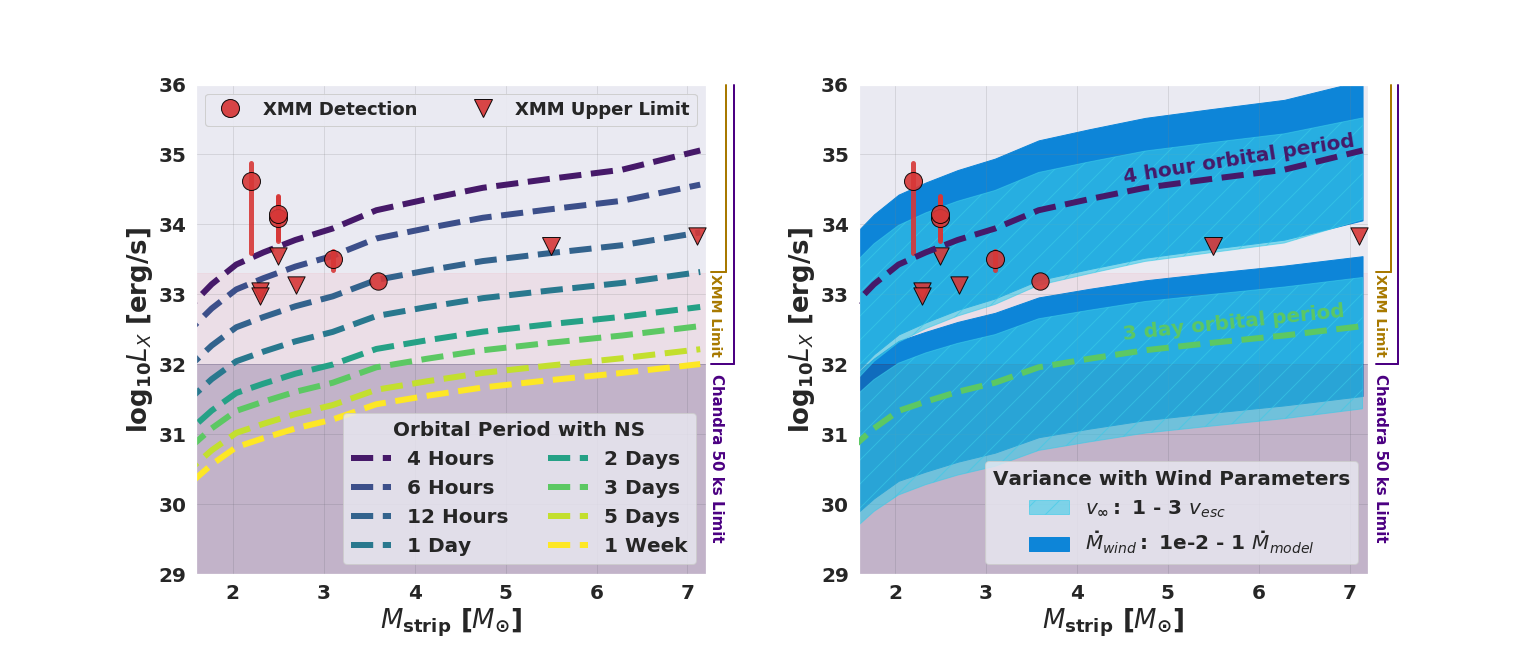

In [16]:
#colors = ["#9400D3","#0000FF","#00FF00","#FFFF00",'#FF7F00','#FF0000']
colors = ["#461969ff","#3c4f8aff","#33638DFF","#29788eff","#25a186ff","#5cc863ff","#c3df2eff","#fde725ff"]
fig,(ax,bx) = plt.subplots(1,2,figsize=(2*10+1,10-1))


# First Plot 
periods = [ 4/24, 6/24, 0.5, 1. ,2.,3.,5., 7.]

period_labels = ["4 Hours","6 Hours","12 Hours","1 Day","2 Days","3 Days","5 Days","1 Week"]



# Luminosity for a given Period 
xraytracks = []
for single_period,label,color in zip(periods,period_labels,colors):
    
    Xray = xray(df,single_period)

    Xray_L = np.log10(Xray.neutron_star_luminosity.value)
    
    xt, = ax.plot(Xray.M_stripped / const.M_sun, Xray_L,label=label,c=color,ls="--",lw=6)
    
    xraytracks.append(xt)

# Things I want Consistent Between Both Axis 
for axes in [ax,bx]:
    axes.set_xlabel("$M_{\\mathrm{strip}}$ [$M_{\\odot}$]",fontsize=labelsize)
    axes.set_ylabel("$\\log_{10} L_X$ [erg/s]",fontsize=labelsize)
    
    #lg = axes.legend(fontsize=ticksize,loc="lower right",title="Orbital Period with NS",ncol=2)
    #lg.get_title().set_fontsize(ticksize)
    axes.grid(c="gray", alpha=0.2)
    axes.set_xlim(1.6,7.2)
    axes.set_ylim(29,36)
    axes.set_xticks(ticks=[2,3,4,5,6,7])
    axes.set_xticklabels([2,3,4,5,6,7], fontsize=ticksize)
    axes.set_yticks([29,30,31,32,33,34,35,36])
    axes.set_yticklabels([29,30,31,32,33,34,35,36], fontsize=ticksize)
    
    # Detection Limits
    axes.fill_between(np.arange(1.5,8),np.repeat(32,len(np.arange(1.5,8))),alpha=0.2,color="#1f0954",zorder=1)

    axes.fill_between(np.arange(1.5,8),np.repeat(33.3,len(np.arange(1.5,8))),alpha=0.1,color="#fd798f",zorder=0)
    
    # Current Obervations 
    lmc2273 = np.log10(np.mean(np.array([4.15e33,2.2e33]))) #2273
    smc2857 = np.log10(np.mean(np.array([2.46e34,1.24e34,1.07e34,6.08e33,8.16e33]))) #m2
    smc4332 = np.log10(np.mean(np.array([1.12e34,2.53e34,0.57e34]))) #m1
    smc6519 = np.log10(np.mean(np.array([7.64e34,7.27e34,4.55e34,2.75e34,2.06e34,3.62e34,7.10e34,2.64e34,0.39e34]))) #6519

    source_L = [lmc2273,smc2857,smc4332,smc6519]
    source_M = [3.1,2.5,2.5,2.2]

    obsv_color="#D63737"
    a_m=0.9
    s1,= axes.plot(source_M,source_L,ms=18,c=obsv_color,zorder=10,marker='o',ls='None',markeredgecolor="black",alpha=a_m) # The four detections
    axes.scatter(3.6,np.log10(1.53e33),s=300,c=obsv_color,edgecolor="black",zorder=10,alpha=a_m) #835

    # The range of the detections
    axes.plot([3.1,3.1],[np.log10(2.2e33),np.log10(4.15e33)],lw=5,c=obsv_color,zorder=9,alpha=a_m)
    axes.plot([2.5,2.5],[np.log10(6.08e33),np.log10(2.46e34)],lw=5,c=obsv_color,zorder=9,alpha=a_m)
    axes.plot([2.5,2.5],[np.log10(0.57e34),np.log10(2.53e34)],lw=5,c=obsv_color,zorder=9,alpha=a_m)
    axes.plot([2.2,2.2],[np.log10(0.39e34),np.log10(7.64e34)],lw=5,c=obsv_color,zorder=9,alpha=a_m)

    # The Upper Limits
    s2,=axes.plot(5.5,np.log10(4.9e33),marker="v",ms=18,c=obsv_color,zorder=10,ls='None',markeredgecolor="black",alpha=a_m) #156
    axes.scatter(2.3,np.log10(1.12e33),marker="v",s=300,c=obsv_color,edgecolor="black",zorder=10,alpha=a_m)  #m02
    axes.scatter(2.7,np.log10(1.35e33),marker="v",s=300,c=obsv_color,edgecolor="black",zorder=10,alpha=a_m) #4349
    axes.scatter(2.3,np.log10(9.49e32),marker="v",s=300,c=obsv_color,edgecolor="black",zorder=10,alpha=a_m) #206
    axes.scatter(7.1,np.log10(6.71e33),marker="v",s=300,c=obsv_color,edgecolor="black",zorder=10,alpha=a_m) #a18
    axes.scatter(2.5,np.log10(3.5e33),marker="v",s=300,c=obsv_color,edgecolor="black",zorder=10,alpha=a_m) #6198




plt.subplots_adjust(wspace=0.3)


chandracolor = "indigo"

xmmcolor = "#a87900"

ax2 = plt.axes([0,0,1,1], facecolor=(1,1,1,0))
x_l = 0.4755
l_width = 2

ax.text(7.23,32.15,"XMM Limit",fontsize=14,rotation=-90,c=xmmcolor,fontweight="bold")
line = lines.Line2D([x_l, x_l], [0.59, 0.88], lw=l_width, color=xmmcolor, alpha=1)
line5 = lines.Line2D([x_l-.01,x_l], [0.59, 0.59], lw=l_width, color=xmmcolor, alpha=1)


ax.text(7.235,29.5,"Chandra 50 ks Limit",fontsize=15,rotation=-90,c=chandracolor,fontweight="bold")
line2 = lines.Line2D([x_l+0.005,x_l+0.005], [0.448, 0.88], lw=l_width, color=chandracolor, alpha=1)
line3 = lines.Line2D([x_l-.01,x_l+0.005], [0.448, 0.448], lw=l_width, color=chandracolor, alpha=1)


ax2.add_line(line)
ax2.add_line(line2)
ax2.add_line(line3)
ax2.add_line(line5)
ax2.set_frame_on(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)



periods=np.array(periods)
# SECOND PLOT 
def plot_range(period,label,vlabel=None,dmlabel=None):
    v_coeff_range = [1,3]
    dM_wind_range = [1e-2,1]

    default = xray(df,period)
    luminosity_default = np.log10(default.neutron_star_luminosity.value)

    # Vary v coefficient only 
    v_max = xray(df,period,v_inf_coeff=v_coeff_range[1])
    v_min = xray(df,period,v_inf_coeff=v_coeff_range[0])


    xray_v_max= np.log10(v_max.neutron_star_luminosity.value)
    xray_v_min = np.log10(v_min.neutron_star_luminosity.value)

    c = colors[np.where(periods == period)[0][0]]
    bx.plot(default.M_stripped / const.M_sun,luminosity_default,c=c,ls="--",lw=6,zorder=10)
    
    fill_c1 = "#3ACBE8"
    fill_c2 = "#0D85D8"
    
    bx.fill_between(v_min.M_stripped / const.M_sun,xray_v_min,xray_v_max,color=fill_c1,zorder=1,label=vlabel,alpha=0.6,hatch="/")


    # Vary wind mass loss rate only 
    dm_max = xray(df,period,dM_wind_coeff=dM_wind_range[1])
    dm_min = xray(df,period,dM_wind_coeff=dM_wind_range[0])


    xray_dm_max = np.log10(dm_max.neutron_star_luminosity.value)
    xray_dm_min = np.log10(dm_min.neutron_star_luminosity.value)

    bx.fill_between(dm_min.M_stripped / const.M_sun,xray_dm_min,xray_dm_max,alpha=1,color=fill_c2,zorder=0,label=dmlabel)

plot_range(3,"3 Day Period",r"$v_{\infty}:$ 1 - 3 $v_{esc}$",r"$\dot{M}_{wind}:$ 1e-2 - 1 $\dot{M}_{model}$")
plot_range(4/24,"4 Hour Period")

bxl = bx.legend(fontsize=ticksize,loc="lower right",title="Variance with Wind Parameters",ncol=1)
bxl.get_title().set_fontsize(ticksize)

x_l = 0.915


bx.text(7.25,32.15,"XMM Limit",fontsize=14,rotation=-90,c=xmmcolor,fontweight="bold")
line = lines.Line2D([x_l, x_l], [0.59, 0.88], lw=l_width, color=xmmcolor, alpha=1)
line5 = lines.Line2D([x_l-.01,x_l], [0.59, 0.59], lw=l_width, color=xmmcolor, alpha=1)


bx.text(7.25,29.5,"Chandra 50 ks Limit",fontsize=15,rotation=-90,c=chandracolor,fontweight="bold")
line2 = lines.Line2D([x_l+0.005,x_l+0.005], [0.448, 0.88], lw=l_width, color=chandracolor, alpha=1)
line3 = lines.Line2D([x_l-.01,x_l+0.005], [0.448, 0.448], lw=l_width, color=chandracolor, alpha=1)


ax2.add_line(line)
ax2.add_line(line2)
ax2.add_line(line3)
ax2.add_line(line5)

bx.text(4.5,32.35,"3 day orbital period",rotation=6,color=colors[np.where(periods == 3)[0][0]],size=ticksize,fontweight="bold",zorder=10)

bx.text(4.5,34.6,"4 hour orbital period",rotation=9,color=colors[np.where(periods == 4/24)[0][0]],size=ticksize,fontweight="bold",zorder=10)



# Legend 
legend0 = ax.legend(xraytracks,period_labels,fontsize=ticksize,loc="lower right",title="Orbital Period with NS",ncol=2)
legend1 = ax.legend([s1,s2],['XMM Detection','XMM Upper Limit'],loc=1,ncol=2,mode="expand",fontsize=ticksize-2)
legend0.get_title().set_fontsize(ticksize)
ax.add_artist(legend1)
ax.add_artist(legend0)



plt.savefig("Xray.png")

In [5]:
Xray = xray(df,4/24)

0.16666666666666666: 6.402831436573124
0.25: 7.704886431777627
0.5: 9.387503163438186
1.0: 10.65869041847205
2.0: 11.612590290313815
3.0: 12.132007165245339
5.0: 12.632346126531944


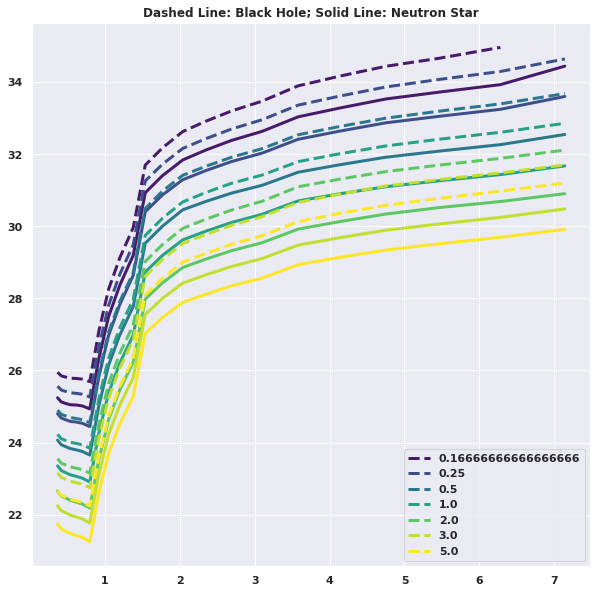

In [32]:
f, axes = plt.subplots(1,1,figsize=(10,10))

for i,p in enumerate([ 4/24, 6/24, 0.5, 1. ,2.,3.,5.]):
    
    Xray = xray(df,p,adaf_flag=True)
    
    axes.plot(Xray.M_stripped/const.M_sun,np.log10(Xray.black_hole_luminosity.value),ls="--",label=p,c=colors[i],lw=3)
    axes.plot(Xray.M_stripped/const.M_sun,np.log10(Xray.neutron_star_luminosity.value),c=colors[i],lw=3)


    
    print(str(p)+': ' +str(np.nanmean(Xray.black_hole_luminosity.value/Xray.neutron_star_luminosity.value)))
axes.set_title("Dashed Line: Black Hole; Solid Line: Neutron Star")    
axes.legend()    
# Dashed xray solid ns

In [10]:
np.nanmean(Xray.black_hole_luminosity.value/Xray.neutron_star_luminosity.value)

5.107252035553118

## f, axes = plt.subplots(1,1,figsize=(10,10))

for i,p in enumerate([ 4/24, 6/24, 0.5, 1. ,2.,3.,5.]):
    
    Xray_adaf = xray(df,p,adaf_flag=True)
    Xray = xray(df,p)
    
    axes.plot(Xray_adaf.M_stripped/const.M_sun,np.log10(Xray_adaf.black_hole_luminosity.value),ls="--",label=p,c=colors[i],lw=3)
    axes.plot(Xray.M_stripped/const.M_sun,np.log10(Xray.neutron_star_luminosity.value),c=colors[i],lw=3)


    
    print(str(p)+': ' +str(np.nanmean(Xray_adaf.black_hole_luminosity.value/Xray.neutron_star_luminosity.value)))
axes.set_title("Dashed Line: Black Hole; Solid Line: Neutron Star")    
axes.legend()    